# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [10]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import utils as utils
import ameritrade_functions as amc

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IRAHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IRA']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-12-04 23:38:49,488|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-12-04 23:38:50,603|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-12-04 00:00:00|2022-12-02 00:00:00
2022-12-04 23:38:50,638|IRAHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-12-04 23:38:50,639|IRAHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-12-04 23:38:50,857|IRAHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-12-04 23:38:50,878|IRAHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.08
2022-12-04 23:38:50,879|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.15
2022-12-04 23:38:50,884|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

c:\users\hp-z440\anaconda projects\svi-trading-tools\tools\utils.py:338: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean().fillna(0)


In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-12-04 23:42:23,712|IRAHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.85|501->428


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-12-04 23:42:23,745|IRAHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|428
2022-12-04 23:42:23,811|IRAHoldingsAdjustement|INFO|OPT_DATE|2022-12-02 00:00:00


2022-12-04 23:42:36,196|IRAHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.02269595


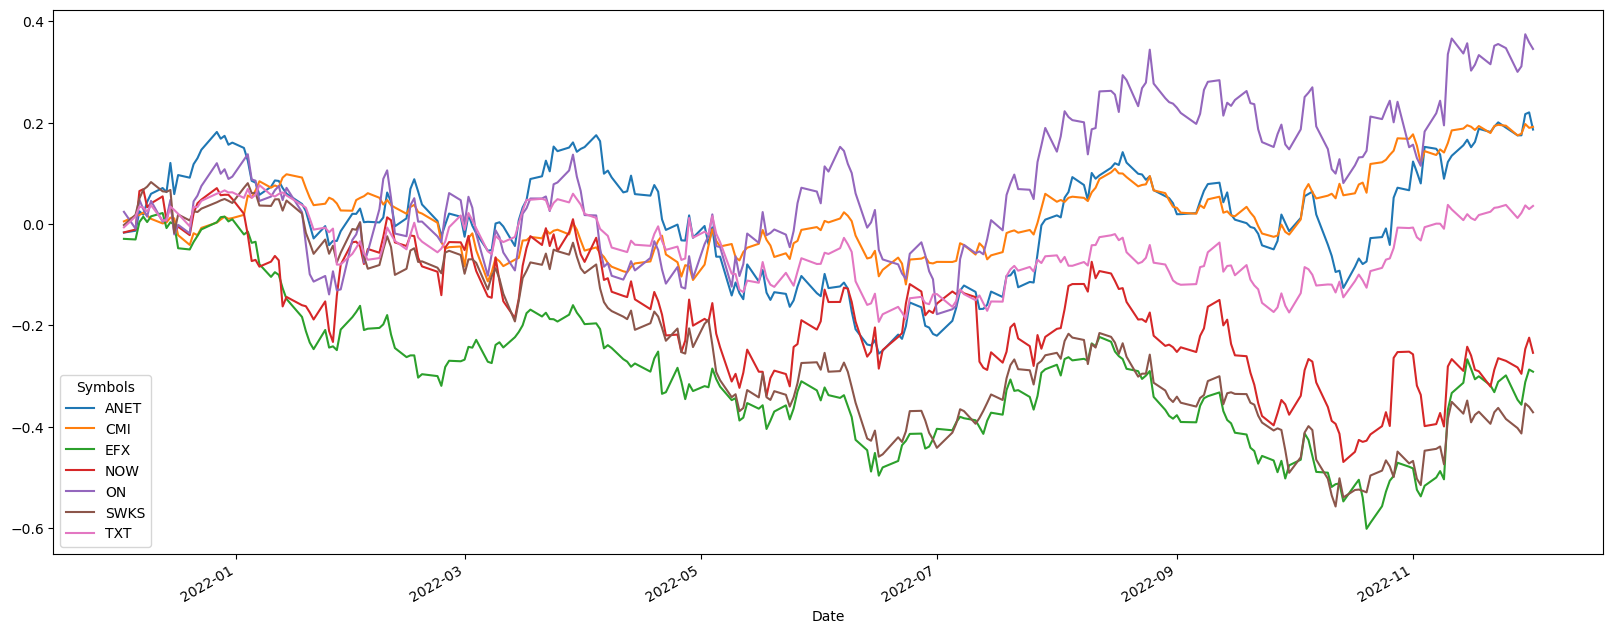

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-12-04 23:42:36,592|IRAHoldingsAdjustement|INFO|STOCK|ANET                |HOLDING|0.100000
2022-12-04 23:42:36,592|IRAHoldingsAdjustement|INFO|STOCK|CMI                 |HOLDING|0.150000
2022-12-04 23:42:36,592|IRAHoldingsAdjustement|INFO|STOCK|EFX                 |HOLDING|0.150000
2022-12-04 23:42:36,592|IRAHoldingsAdjustement|INFO|STOCK|NOW                 |HOLDING|0.150000
2022-12-04 23:42:36,602|IRAHoldingsAdjustement|INFO|STOCK|ON                  |HOLDING|0.150000
2022-12-04 23:42:36,603|IRAHoldingsAdjustement|INFO|STOCK|SWKS                |HOLDING|0.150000
2022-12-04 23:42:36,603|IRAHoldingsAdjustement|INFO|STOCK|TXT                 |HOLDING|0.150000


In [11]:
td_ameritrade = amc.AmeritradeRest()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,883203101,TXT,Textron Inc. Common Stock,NYSE,EQUITY,79.4500,57.110,0.08,0.11,2022-12-08 00:00:00.000,...,8.78702,0.0,0.0,0.0,0.02,2023-01-01 00:00:00.000,1.51071,1041570.0,1041571.0,27385190.0
1,040413106,ANET,"Arista Networks, Inc. Common Stock",NYSE,EQUITY,148.5700,89.115,0.00,0.00,,...,27.01769,0.0,0.0,0.0,0.00,,1.28304,1605270.0,1605265.0,48297210.0
2,294429105,EFX,"Equifax, Inc. Common Stock",NYSE,EQUITY,300.1100,145.980,1.56,0.77,2022-11-22 00:00:00.000,...,5.74006,0.0,0.0,0.0,0.39,2022-12-15 00:00:00.000,1.44995,869730.0,869731.0,21786230.0
3,81762P102,NOW,"ServiceNow, Inc. Common Stock",NYSE,EQUITY,672.9700,337.000,0.00,0.00,,...,51.60758,0.0,0.0,0.0,0.00,,0.97302,1253780.0,1253781.0,38205460.0
4,83088M102,SWKS,"Skyworks Solutions, Inc. - Common Stock",NASDAQ,EQUITY,164.4700,76.160,2.48,2.64,2022-11-21 00:00:00.000,...,8.98323,0.0,0.0,0.0,0.62,2022-12-13 00:00:00.000,1.21128,1770670.0,1770666.0,43414900.0
5,231021106,CMI,Cummins Inc. Common Stock,NYSE,EQUITY,254.0850,184.275,6.28,2.51,2022-11-17 00:00:00.000,...,7.78675,0.0,0.0,0.0,1.57,2022-12-01 00:00:00.000,1.05245,919450.0,919449.0,19710120.0
6,682189105,ON,ON Semiconductor Corporation - Common Stock,NASDAQ,EQUITY,77.2812,44.760,0.00,0.00,,...,19.06774,0.0,0.0,0.0,0.00,,1.72814,4774760.0,4774759.0,145180720.0


Tickers:   0%|          | 0/7 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/7 [00:00<?, ?News Table Items/s]

C:\Users\HP-Z440\AppData\Local\Temp\ipykernel_18804\1254735451.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


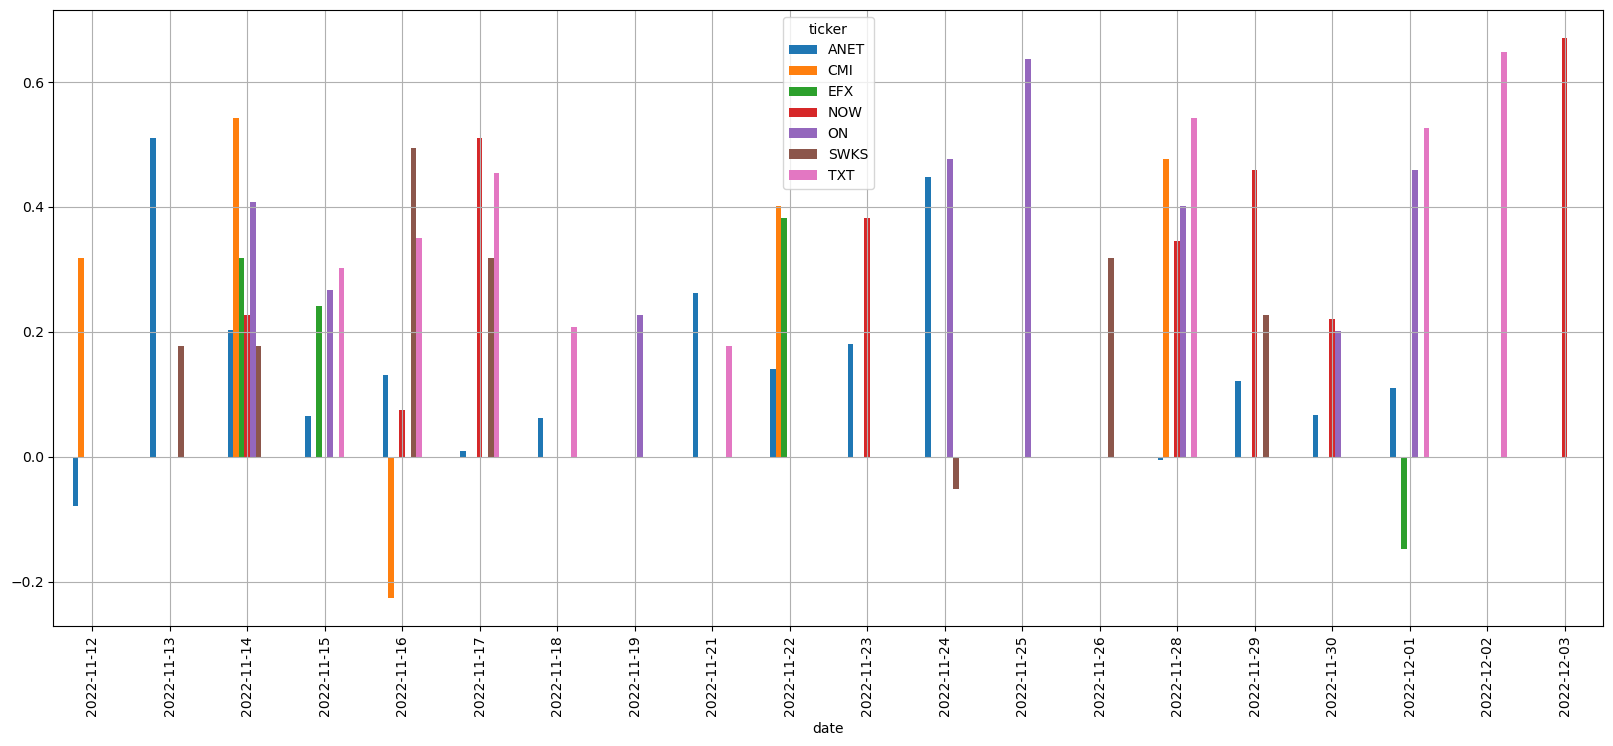

In [12]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [13]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 SCHF              0.0      35.56279             0.0   
         VTIP              0.0      52.14316             0.0   
         VGK               0.0      59.10313             0.0   
         FNCL              0.0      40.44691             0.0   
         FSTA              0.0      42.61006             0.0   
         SCHM              0.0      77.86802             0.0   
         VWO               0.0      50.42377             0.0   
         VBR               0.0     169.07886             0.0   
         EQT               0.0      42.01000             0.0   
         FGPHF             0.0       0.12293             0.0   
         STZ               0.0     258.00000             0.0   
         WKHS              0.0      12.43990             0.0   
         WTW               0.0     243.54533             0.0   
         GRMN              0.0      90.77000             0.0   
         EEENF             0.0       0.04960             0.0   
         LW                0.0      86.09044             0.0   
         VOO               0.0     370.43264             0.0   
         OKE               0.0      64.38492             0.0   
         UAL               0.0      43.82402             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 SCHF                     0.0                             0.0   
         VTIP                     0.0                             0.0   
         VGK                      0.0                             0.0   
         FNCL                     0.0                             0.0   
         FSTA                     0.0                             0.0   
         SCHM                     0.0                             0.0   
         VWO                      0.0                             0.0   
         VBR                      0.0                             0.0   
         EQT                      0.0                             0.0   
         FGPHF                    0.0                             0.0   
         STZ                      0.0                             0.0   
         WKHS                     0.0                             0.0   
         WTW                      0.0                             0.0   
         GRMN                     0.0                             0.0   
         EEENF                    0.0                             0.0   
         LW                       0.0                             0.0   
         VOO                      0.0                             0.0   
         OKE                      0.0                             0.0   
         UAL                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 SCHF          60.707               60.707                   0.0   
         VTIP          71.973               71.973                   0.0   
         VGK           35.925               35.925                   0.0   
         FNCL          13.224               13.224                   0.0   
         FSTA           5.088                5.088                   0.0   
         SCHM          20.291               20.291                   0.0   
         VWO           15.362               15.362                   0.0   
         VBR            3.094                3.094                   0.0   
         EQT           60.000               60.000                   0.0   
         FGPHF     100000.000           100000.000                   0.0   
         STZ           15.000               15.000                   0.0   
         WKHS        1000.000             1000.000                   0.0   
         WTW           15.000               15.000                   0.0  

In [14]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 EQT               0.0      42.01000             0.0   
         STZ               0.0     258.00000             0.0   
         WTW               0.0     243.54533             0.0   
         GRMN              0.0      90.77000             0.0   
         LW                0.0      86.09044             0.0   
         OKE               0.0      64.38492             0.0   
         UAL               0.0      43.82402             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 EQT                      0.0                             0.0   
         STZ                      0.0                             0.0   
         WTW                      0.0                             0.0   
         GRMN                     0.0                             0.0   
         LW                       0.0                             0.0   
         OKE                      0.0                             0.0   
         UAL                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 EQT             60.0                 60.0                   0.0   
         STZ             15.0                 15.0                   0.0   
         WTW             15.0                 15.0                   0.0   
         GRMN            42.0                 42.0                   0.0   
         LW              45.0                 45.0                   0.0   
         OKE             59.0                 59.0                   0.0   
         UAL             87.0                 87.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---5311 EQT         2395.80                 2395.80   
         STZ         3915.75                 3915.75   
         WTW         3713.40                 3713.40   
         GRMN        3961.44                 3961.44   
         LW          3947.85                 3947.85   
         OKE         3964.80                 3964.80   
         UAL         3818.43                 3818.43   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---5311 EQT                            60.0    EQUITY  26884L109           0   
         STZ                            15.0    EQUITY  21036P108           0   
         WTW                            15.0    EQUITY  G96629103           0   
         GRMN                           42.0    EQUITY  H2906T109           0   
         LW                             45.0    EQUITY  513272104           0   
         OKE                            59.0    EQUITY  682680103           0   
         UAL                            87.0    EQUITY  910047109           0   

                type  
account  symbol       
#---5311 EQT       0  
         STZ       0  
         WTW       0  
         GRMN      0  
         LW        0  
         OKE       0  
         UAL       0

### Submit and montior sell orders

In [15]:
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

Placing SELL order on #---5311 for 60.0 shares of EQT...
Placed SELL order on #---5311 for 60.0 shares of EQT
Placing SELL order on #---5311 for 15.0 shares of STZ...
Placed SELL order on #---5311 for 15.0 shares of STZ
Placing SELL order on #---5311 for 15.0 shares of WTW...
Placed SELL order on #---5311 for 15.0 shares of WTW
Placing SELL order on #---5311 for 42.0 shares of GRMN...
Placed SELL order on #---5311 for 42.0 shares of GRMN
Placing SELL order on #---5311 for 45.0 shares of LW...
Placed SELL order on #---5311 for 45.0 shares of LW
Placing SELL order on #---5311 for 59.0 shares of OKE...
Placed SELL order on #---5311 for 59.0 shares of OKE
Placing SELL order on #---5311 for 87.0 shares of UAL...
Placed SELL order on #---5311 for 87.0 shares of UAL


In [ ]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


In [16]:
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

initialBalances_cashBalance           39.38000
initialBalances_totalCash              0.00000
initialBalances_equity             95101.53000
initialBalances_moneyMarketFund     1161.15000
currentBalances_cashBalance        25603.14000
currentBalances_equity             94615.81000
currentBalances_moneyMarketFund     1200.53000
current_return                        -0.00512
Name: #---5311, dtype: float64

25603.14
1200.53


In [17]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 26803.67
Amount to invest: 26000


In [18]:
long_weights

,optimalWeights
ANET,0.10
CMI,0.15
EFX,0.15
NOW,0.15
ON,0.15
SWKS,0.15
TXT,0.15


In [19]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = td_ameritrade.get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-12-05 09:48:54.536999
Initial investment amount: 26000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
ANET,135.04,0.10,2600.0,19
CMI,249.75,0.15,3900.0,15
EFX,201.38,0.15,3900.0,19
NOW,412.87,0.15,3900.0,9
ON,73.04,0.15,3900.0,53
SWKS,93.96,0.15,3900.0,41
TXT,71.30,0.15,3900.0,54


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
ANET,135.04,0.10,2600.0,19,2565.76
CMI,249.75,0.15,3900.0,15,3746.25
EFX,201.38,0.15,3900.0,19,3826.22
NOW,412.87,0.15,3900.0,9,3715.83
ON,73.04,0.15,3900.0,53,3871.12
SWKS,93.96,0.15,3900.0,41,3852.36
TXT,71.30,0.15,3900.0,54,3850.20


Total cost: 25427.74


### Place buy orders

In [20]:
td_ameritrade.get_quotes(long_weights.index.to_list())
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,883203101,TXT,Textron Inc. Common Stock,NYSE,EQUITY,79.4500,57.110,0.08,0.11,2022-12-08 00:00:00.000,...,8.78702,0.0,0.0,0.0,0.02,2023-01-01 00:00:00.000,1.51071,1041570.0,1041571.0,27385190.0
1,040413106,ANET,"Arista Networks, Inc. Common Stock",NYSE,EQUITY,148.5700,89.115,0.00,0.00,,...,27.01769,0.0,0.0,0.0,0.00,,1.28304,1605270.0,1605265.0,48297210.0
2,294429105,EFX,"Equifax, Inc. Common Stock",NYSE,EQUITY,300.1100,145.980,1.56,0.77,2022-11-22 00:00:00.000,...,5.74006,0.0,0.0,0.0,0.39,2022-12-15 00:00:00.000,1.44995,869730.0,869731.0,21786230.0
3,81762P102,NOW,"ServiceNow, Inc. Common Stock",NYSE,EQUITY,672.9700,337.000,0.00,0.00,,...,51.60758,0.0,0.0,0.0,0.00,,0.97302,1253780.0,1253781.0,38205460.0
4,83088M102,SWKS,"Skyworks Solutions, Inc. - Common Stock",NASDAQ,EQUITY,164.4700,76.160,2.48,2.64,2022-11-21 00:00:00.000,...,8.98323,0.0,0.0,0.0,0.62,2022-12-13 00:00:00.000,1.21128,1770670.0,1770666.0,43414900.0
5,231021106,CMI,Cummins Inc. Common Stock,NYSE,EQUITY,254.0850,184.275,6.28,2.51,2022-11-17 00:00:00.000,...,7.78675,0.0,0.0,0.0,1.57,2022-12-01 00:00:00.000,1.05245,919450.0,919449.0,19710120.0
6,682189105,ON,ON Semiconductor Corporation - Common Stock,NASDAQ,EQUITY,77.2812,44.760,0.00,0.00,,...,19.06774,0.0,0.0,0.0,0.00,,1.72814,4774760.0,4774759.0,145180720.0


In [21]:
print(datetime.today())
#td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
#td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-12-05 09:49:12.116903
Placing BUY order on 495855311 for 19.0 shares of ANET:EQUITY...
Placed BUY order on #---5311 for 19.0 shares of ANET
Placing BUY order on 495855311 for 15.0 shares of CMI:EQUITY...
Placed BUY order on #---5311 for 15.0 shares of CMI
Placing BUY order on 495855311 for 19.0 shares of EFX:EQUITY...
Placed BUY order on #---5311 for 19.0 shares of EFX
Placing BUY order on 495855311 for 9.0 shares of NOW:EQUITY...
Placed BUY order on #---5311 for 9.0 shares of NOW
Placing BUY order on 495855311 for 53.0 shares of ON:EQUITY...
Placed BUY order on #---5311 for 53.0 shares of ON
Placing BUY order on 495855311 for 41.0 shares of SWKS:EQUITY...
Placed BUY order on #---5311 for 41.0 shares of SWKS
Placing BUY order on 495855311 for 54.0 shares of TXT:EQUITY...
Placed BUY order on #---5311 for 54.0 shares of TXT


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]